<a href="https://colab.research.google.com/github/ig-quinzel/Cognizant-hackathon/blob/model_building/dynamic_pricing_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Dynamic pricing**

In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from google.colab import files
from datetime import datetime
print("Upload your CSV dataset:")
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)

# 3. Encode Categorical Features
categorical_cols = [
    "region_Europe", "region_North America",
    "store_type_Retail", "store_type_Wholesale",
    "category_Cabinets", "category_Chairs",
    "category_Sofas", "category_Tables"
]

encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

# 4. Feature Engineering
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop('date', axis=1)

# 5. Define Features and Target
target_column = 'price'
feature_cols = [
    'product_id', 'sales_units', 'holiday_season', 'promotion_applied',
    'competitor_price_index', 'economic_index', 'weather_impact',
    'discount_percentage', 'sales_revenue',
    'region_Europe', 'region_North America',
    'store_type_Retail', 'store_type_Wholesale',
    'category_Cabinets', 'category_Chairs',
    'category_Sofas', 'category_Tables',
    'year', 'month', 'day'
]

X = df[feature_cols].copy()   # make an explicit copy

y = df[target_column]

numeric_cols = [
    'sales_units', 'competitor_price_index', 'economic_index',
    'weather_impact', 'discount_percentage', 'sales_revenue',
    'year', 'month', 'day'
]
scaler = StandardScaler()
X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Model Performance for Dynamic Pricing")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

print("\nEnter product and market details to predict dynamic price:")

try:
    user_input = {}
    user_input['product_id'] = int(input("Product ID: "))
    user_input['sales_units'] = int(input("Sales Units: "))
    user_input['holiday_season'] = int(input("Holiday Season (1 for Yes, 0 for No): "))
    user_input['promotion_applied'] = int(input("Promotion Applied (1/0): "))
    user_input['competitor_price_index'] = float(input("Competitor Price Index: "))
    user_input['economic_index'] = float(input("Economic Index: "))
    user_input['weather_impact'] = float(input("Weather Impact: "))
    user_input['discount_percentage'] = float(input("Discount Percentage (0-1): "))
    user_input['sales_revenue'] = float(input("Sales Revenue: "))

    for col in categorical_cols:
        val = input(f"{col} (string): ")
        if val in encoders[col].classes_:
            user_input[col] = encoders[col].transform([val])[0]
        else:
            encoders[col].classes_ = np.append(encoders[col].classes_, val)
            user_input[col] = encoders[col].transform([val])[0]

    date_str = input("Date (dd-mm-yyyy): ")
    dt = datetime.strptime(date_str, '%d-%m-%Y')
    user_input['year'] = dt.year
    user_input['month'] = dt.month
    user_input['day'] = dt.day

    input_df = pd.DataFrame([user_input])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df = input_df[feature_cols]

    predicted_price = xgb_model.predict(input_df)[0]
    print(f"\n Predicted Dynamic Price: ${predicted_price:.2f}")

except Exception as e:
    print("Error in user input:", e)


In [ ]:
xgb_model.fit(X_train, y_train)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Model Performance for Dynamic Pricing")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

### **EXPLAINABLE AI-SHAP**

In [ ]:
!pip install shap


In [ ]:
import shap
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.plots.force(shap_values[0])

shap.plots.beeswarm(shap_values)
user_shap_values = explainer(input_df)

shap_df = pd.DataFrame({
    'Feature': input_df.columns,
    'Value': input_df.iloc[0],
    'SHAP_Contribution': user_shap_values.values[0]
}).sort_values(by='SHAP_Contribution', key=abs, ascending=False)

print(shap_df)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load dataset
df = pd.read_csv("demand_forecasting_dataset.csv")

# Convert date
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Encode booleans
df = df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0})

# Encode categorical columns
label_enc = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object' and col != 'date':
        df[col] = label_enc.fit_transform(df[col].astype(str))

# Features and target
X = df.drop(['date','future_demand'], axis=1)
y = df['future_demand']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)  # time-based split

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")


📂 Upload your CSV dataset:


Saving demand_forecasting_dataset.csv to demand_forecasting_dataset (27).csv
✅ XGBoost Model Performance for Dynamic Pricing
MAE : 2.7477
RMSE: 4.0585
R²  : 0.9937


 97%|=================== | 974/1000 [00:24<00:00]       

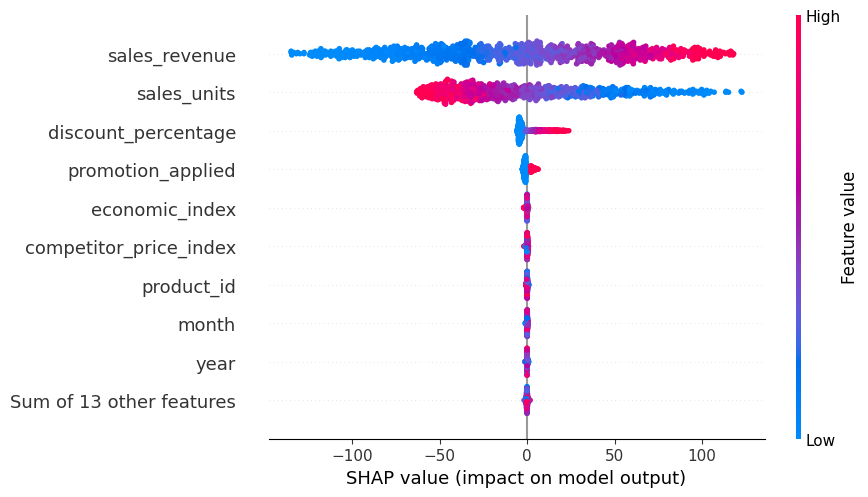

Random Forest Demand Forecasting Performance:
MAE : 48.28
RMSE: 56.13
R²  : -0.04


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- price


In [ ]:
def predict_demand(model, scaler, input_data, price, channel):
    df_input = pd.DataFrame([input_data])
    df_input['store_type_Retail'] = 1 if channel.lower() == 'retail' else 0
    df_input['store_type_Wholesale'] = 1 if channel.lower() == 'wholesale' else 0
    df_input['price'] = price  # use raw price if model trained on raw
    df_input[numeric_cols] = scaler.transform(df_input[numeric_cols])
    return model.predict(df_input)[0]

def optimize_price(model, scaler, input_data, channel, price_range):
    revenues = []
    for price in price_range:
        demand = predict_demand(model, scaler, input_data, price, channel)
        revenues.append(demand * price)
    max_idx = np.argmax(revenues)
    return price_range[max_idx], revenues[max_idx]

# Example usage
for channel in channels:
    best_price, max_rev = optimize_price(xgb_model, scaler, input_data, channel, price_range)
    print(f"Optimal Price for {channel}: {best_price:.2f}, Expected Revenue: {max_rev:.2f}")
